In [3]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])


In [17]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
 
 
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
 
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
 
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
 
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
 
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
 
        boxes = torch.as_tensor(boxes)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)


In [18]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
 
 
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
 
    return model


In [19]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
 
 
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [20]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
 
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
 
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)
 
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
 
# our dataset has two classes only - background and person
num_classes = 2
 
# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)
 
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
 
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [24]:
# let's train it for 10 epochs
num_epochs = 10
 
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)


Epoch: [0]  [ 0/60]  eta: 0:00:33  lr: 0.000090  loss: 0.2772 (0.2772)  loss_classifier: 0.0369 (0.0369)  loss_box_reg: 0.0812 (0.0812)  loss_mask: 0.1507 (0.1507)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0080 (0.0080)  time: 0.5505  data: 0.0199  max mem: 3698
Epoch: [0]  [10/60]  eta: 0:00:27  lr: 0.000936  loss: 0.2772 (0.2880)  loss_classifier: 0.0380 (0.0398)  loss_box_reg: 0.1034 (0.1015)  loss_mask: 0.1358 (0.1362)  loss_objectness: 0.0006 (0.0028)  loss_rpn_box_reg: 0.0079 (0.0077)  time: 0.5590  data: 0.0256  max mem: 3698
Epoch: [0]  [20/60]  eta: 0:00:21  lr: 0.001783  loss: 0.2573 (0.2630)  loss_classifier: 0.0291 (0.0332)  loss_box_reg: 0.0743 (0.0856)  loss_mask: 0.1355 (0.1361)  loss_objectness: 0.0006 (0.0023)  loss_rpn_box_reg: 0.0056 (0.0059)  time: 0.5409  data: 0.0260  max mem: 3698
Epoch: [0]  [30/60]  eta: 0:00:16  lr: 0.002629  loss: 0.2573 (0.2715)  loss_classifier: 0.0290 (0.0368)  loss_box_reg: 0.0766 (0.0907)  loss_mask: 0.1219 (0.1358)  loss_ob

Epoch: [4]  [20/60]  eta: 0:00:23  lr: 0.000500  loss: 0.1736 (0.1875)  loss_classifier: 0.0214 (0.0275)  loss_box_reg: 0.0265 (0.0365)  loss_mask: 0.1092 (0.1198)  loss_objectness: 0.0004 (0.0010)  loss_rpn_box_reg: 0.0016 (0.0027)  time: 0.5779  data: 0.0283  max mem: 3698
Epoch: [4]  [30/60]  eta: 0:00:17  lr: 0.000500  loss: 0.1680 (0.1864)  loss_classifier: 0.0230 (0.0279)  loss_box_reg: 0.0323 (0.0373)  loss_mask: 0.1066 (0.1173)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0023 (0.0027)  time: 0.5803  data: 0.0272  max mem: 3698
Epoch: [4]  [40/60]  eta: 0:00:11  lr: 0.000500  loss: 0.1708 (0.1875)  loss_classifier: 0.0257 (0.0279)  loss_box_reg: 0.0342 (0.0388)  loss_mask: 0.1069 (0.1167)  loss_objectness: 0.0003 (0.0013)  loss_rpn_box_reg: 0.0023 (0.0028)  time: 0.5989  data: 0.0304  max mem: 3698
Epoch: [4]  [50/60]  eta: 0:00:05  lr: 0.000500  loss: 0.1797 (0.1912)  loss_classifier: 0.0273 (0.0284)  loss_box_reg: 0.0386 (0.0402)  loss_mask: 0.1113 (0.1184)  loss_ob

Epoch: [8]  [40/60]  eta: 0:00:11  lr: 0.000005  loss: 0.1719 (0.1853)  loss_classifier: 0.0250 (0.0262)  loss_box_reg: 0.0272 (0.0363)  loss_mask: 0.1139 (0.1189)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0018 (0.0026)  time: 0.5974  data: 0.0278  max mem: 3698
Epoch: [8]  [50/60]  eta: 0:00:05  lr: 0.000005  loss: 0.1616 (0.1848)  loss_classifier: 0.0252 (0.0266)  loss_box_reg: 0.0294 (0.0366)  loss_mask: 0.1097 (0.1177)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0023 (0.0026)  time: 0.5948  data: 0.0270  max mem: 3698
Epoch: [8]  [59/60]  eta: 0:00:00  lr: 0.000005  loss: 0.1704 (0.1862)  loss_classifier: 0.0264 (0.0270)  loss_box_reg: 0.0345 (0.0383)  loss_mask: 0.1054 (0.1171)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0020 (0.0026)  time: 0.5692  data: 0.0270  max mem: 3698
Epoch: [8] Total time: 0:00:35 (0.5847 s / it)
Epoch: [9]  [ 0/60]  eta: 0:00:29  lr: 0.000005  loss: 0.1688 (0.1688)  loss_classifier: 0.0202 (0.0202)  loss_box_reg: 0.030

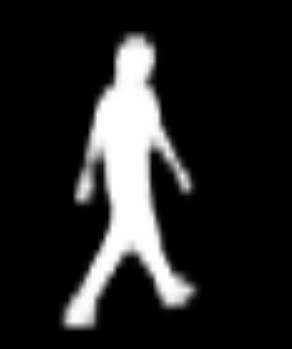

In [26]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
 
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())


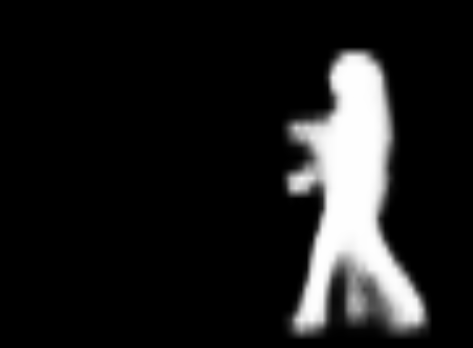

In [25]:
# pick one image from the test set
img, _ = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
 
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())


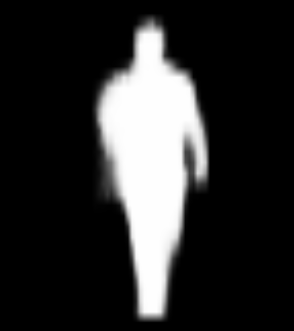

In [27]:
# pick one image from the test set
img, _ = dataset_test[9]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
 
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())


메인!! 

https://wordbe.tistory.com/entry/Object-Detection-%EC%98%88%EC%A0%9C-%EC%84%A4%EB%AA%85-%EC%BD%94%EB%93%9C%ED%8F%AC%ED%95%A8-Pytorch

이걸로 됐고 그냥 참고용
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
